In [1]:
import os
import itertools as it

from dotenv import load_dotenv

import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings



from IPython.display import display

load_dotenv()
project_id = os.getenv("PROJECT_ID")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

TOWERS = ["tower_A", "tower_B", "tower_C", "tower_D"]
METRIC = "system_uptime"

**NOTE**: See the profiled `system_uptime` [here](https://storage.googleapis.com/anduril-case-study/metrics/system_uptime.html).

In [2]:
# Get data
df = pandas_gbq.read_gbq(
    f"select * from metrics.{METRIC}",
    project_id=project_id,
    use_bqstorage_api=True,
)

query = f"""
select
  ts,
  tower_id,
  metric_name,
  metric_value
from `raw_data.long_clean`
where metric_name = '{METRIC}'
"""
df_long_clean = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    use_bqstorage_api=True,
)

df.set_index("ts", inplace=True)
df.drop(columns=["timestamp_ms"], inplace=True)
df.sort_index(inplace=True)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████|


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88339 entries, 2024-01-18 04:48:30+00:00 to 2024-02-17 20:57:30+00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tower_A  86112 non-null  float64
 1   tower_B  21539 non-null  float64
 2   tower_C  20636 non-null  float64
 3   tower_D  21436 non-null  float64
dtypes: float64(4)
memory usage: 3.4 MB


In [4]:
df.describe()

,tower_A,tower_B,tower_C,tower_D
count,86112.000000,21539.000000,20636.000000,21436.000000
mean,79634.143984,79011.574994,64851.195550,44277.986830
std,45797.869236,46173.690950,46509.851781,34778.680589
min,27.600000,23.600000,15.400000,13.200000
25%,34712.850000,32336.349805,20715.300000,16263.775000
50%,86288.150000,86304.000000,59585.017045,32354.650000
75%,118920.625000,118940.550000,105224.350000,74266.800000
max,155555.600000,155559.600000,156011.000000,120869.100000


In [5]:
df['day'] = df.index.date
df_long = df.melt('day', TOWERS)
df.drop('day', axis=1, inplace=True)

In [6]:
(df.shift(-1) - df).describe()

,tower_A,tower_B,tower_C,tower_D
count,86087.000000,0.0,0.0,0.0
mean,0.959347,NaN,NaN,NaN
std,304.985530,NaN,NaN,NaN
min,-58734.440000,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN
50%,3.000000,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN
max,14.800000,NaN,NaN,NaN


**Note**: Seems like the units are *decaseconds* (read: 1 decasecond = 10 seconds).

In [7]:
ex_tower_A, result = [tower for tower in TOWERS if tower != 'tower_A'], []
for tower in ex_tower_A:
    comparison = pd.DataFrame([df['tower_B'].rename('T'), df['tower_B'].shift(1).rename('T+1')]).transpose()
    result.append(comparison[comparison["T"].notnull() & comparison["T+1"].notnull()].empty)

print(list(zip(ex_tower_A, result)))

[('tower_B', True), ('tower_C', True), ('tower_D', True)]


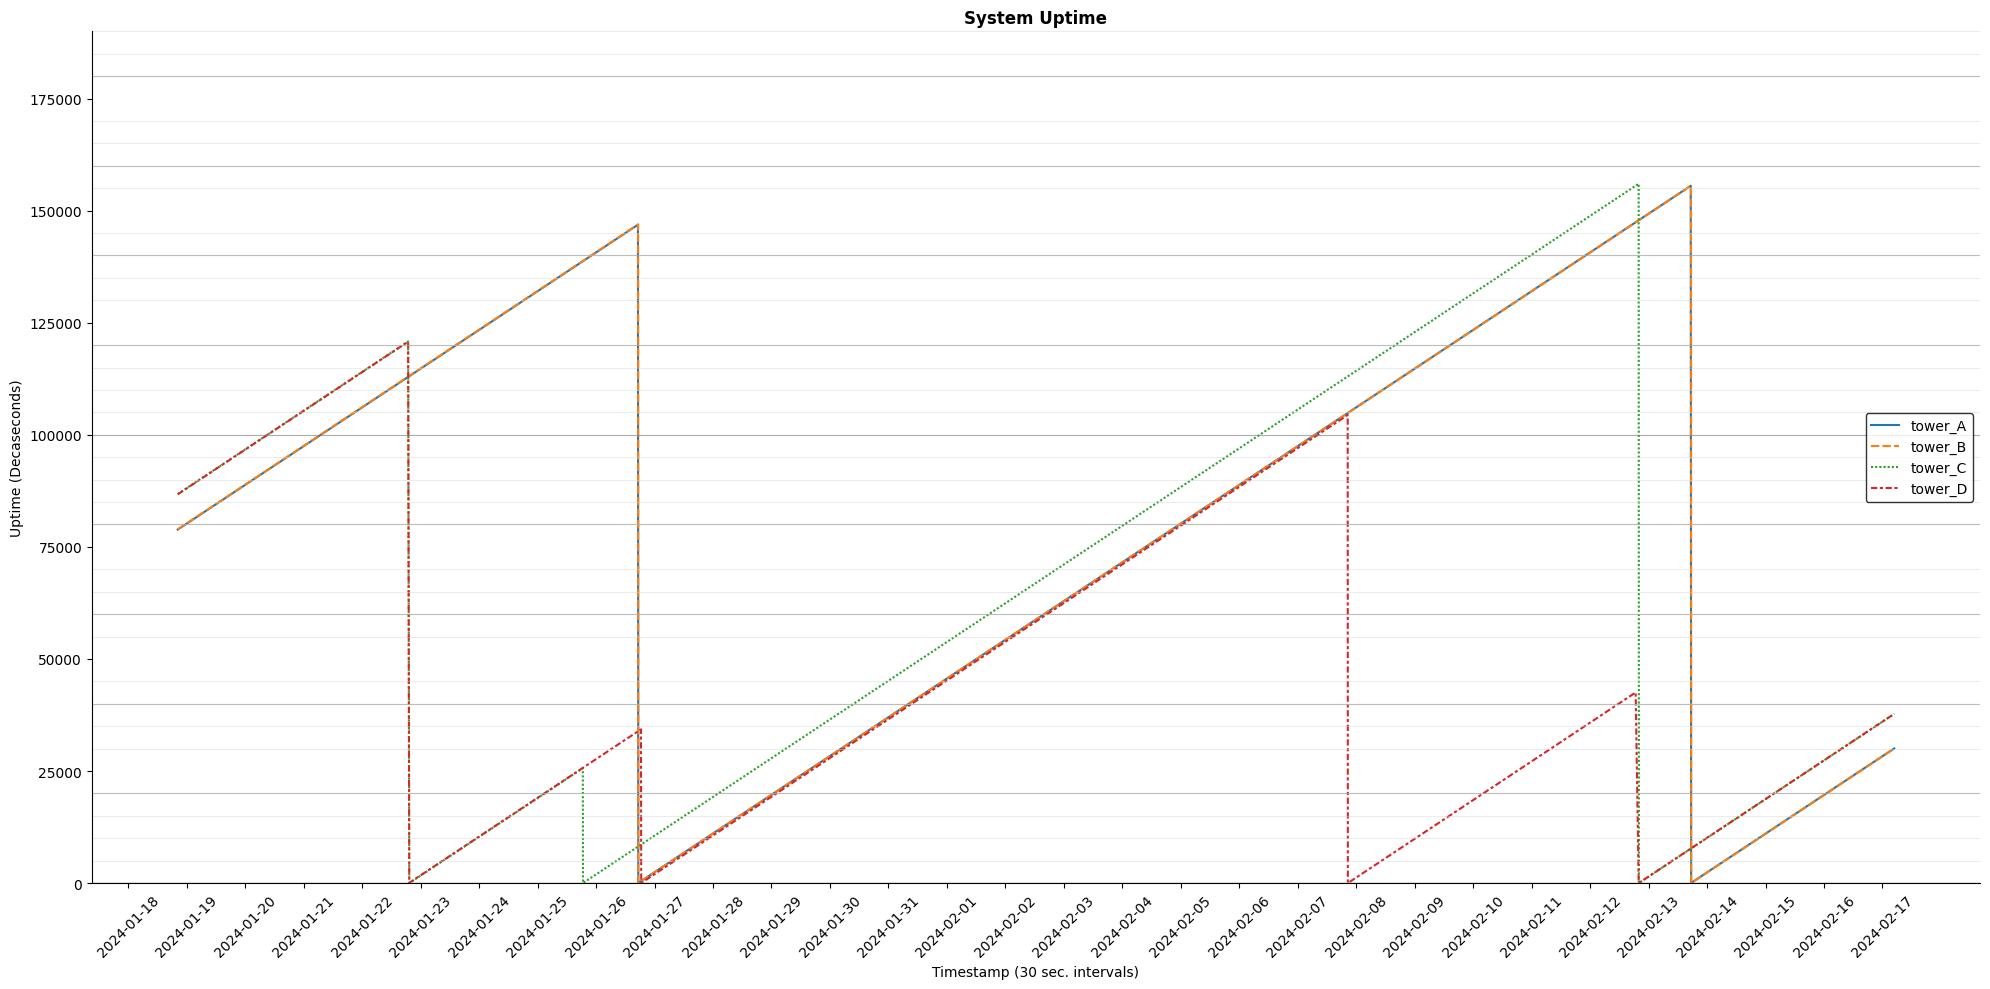

In [8]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(df.dropna())

ax.minorticks_on()
for y in ax.get_yticks():
    lw, a = (0.8, 0.65) if y != 0 else (1, 1)
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=lw, alpha=a)
for y in ax.get_yticks(minor=True):
    ax.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.65)
ax.minorticks_off()

ax.set_xticks(x_values := df_long['day'].unique())
ax.set_xticklabels(x_values, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.title('System Uptime', weight='bold')
plt.xlabel('Timestamp (30 sec. intervals)')
plt.ylabel('Uptime (Decaseconds)')
plt.tight_layout()
plt.legend(title='Tower')
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

In [9]:
df.resample('1d').agg(['mean', 'sem'])

tower_A                     tower_B  \
                                    mean          sem           mean   
ts                                                                     
2024-01-18 00:00:00+00:00   76740.033623    41.581911   78665.994835   
2024-01-19 00:00:00+00:00   84515.200000    46.483860   84570.000189   
2024-01-20 00:00:00+00:00   93155.201042    46.483876   93209.997967   
2024-01-21 00:00:00+00:00  101795.200694    46.483861  101849.999558   
2024-01-22 00:00:00+00:00  110435.199479    46.483851  110489.999558   
2024-01-23 00:00:00+00:00  119075.200000    46.483871  119121.724226   
2024-01-24 00:00:00+00:00  127715.199826    46.483868  127770.000694   
2024-01-25 00:00:00+00:00  136355.199826    46.483880  136410.001537   
2024-01-26 00:00:00+00:00  103743.154841  1194.487815  104264.803533   
2024-01-27 00:00:00+00:00    6761.099479    46.483866    6731.103258   
2024-01-28 00:00:00+00:00   15401.099653    46.483875   15371.098396   
2024-01-29 00:00:00+00:00   24041.100174    46.483870   24011.098864   
2024-01-30 00:00:00+00:00   32681.300590    46.499587   32651.102492   
2024-01-31 00:00:00+00:00   41321.100174    46.483854   41291.102445   
2024-02-01 00:00:00+00:00   49960.300139    46.512742   49931.108598   
2024-02-02 00:00:00+00:00   58601.100174    46.483872   58571.100063   
2024-02-03 00:00:00+00:00   67241.099479    46.483864   67211.100063   
2024-02-04 00:00:00+00:00   75881.101389    46.483889   75851.106056   
2024-02-05 00:00:00+00:00   84523.633356    46.481124   84491.109168   
2024-02-06 00:00:00+00:00   93160.646891    46.497810   93131.101686   
2024-02-07 00:00:00+00:00  101801.100868    46.483840  101771.101843   
2024-02-08 00:00:00+00:00  110375.516510    50.245197  110346.328148   
2024-02-09 00:00:00+00:00  119081.101042    46.483876  119051.102109   
2024-02-10 00:00:00+00:00  127721.100347    46.483867  127691.099558   
2024-02-11 00:00:00+00:00  136361.297117    46.499622  136331.099095   
2024-02-12 00:00:00+00:00  145001.100000    46.483868  144971.101995   
2024-02-13 00:00:00+00:00  110673.656193  1260.905997  111361.152255   
2024-02-14 00:00:00+00:00    6719.799826    46.483867    6677.601540   
2024-02-15 00:00:00+00:00   15326.427510    46.861964   15314.361521   
2024-02-16 00:00:00+00:00   23999.801064    46.483873   23957.599131   
2024-02-17 00:00:00+00:00   29185.300781    20.820663   31013.599362   

                                              tower_C               \
                                   sem           mean          sem   
ts                                                                   
2024-01-18 00:00:00+00:00    56.391687   87358.756548    47.506651   
2024-01-19 00:00:00+00:00    93.016139   92429.399440    93.016121   
2024-01-20 00:00:00+00:00    93.016088  101069.400000    93.016128   
2024-01-21 00:00:00+00:00    93.016066  109709.400000    93.016128   
2024-01-22 00:00:00+00:00    93.016080   93286.891481  1810.586407   
2024-01-23 00:00:00+00:00    93.090852    6003.900000    93.016128   
2024-01-24 00:00:00+00:00    93.016165   14643.899879    93.016122   
2024-01-25 00:00:00+00:00    93.016120   17523.051780   337.703494   
2024-01-26 00:00:00+00:00  2382.022222    6266.968247    93.133127   
2024-01-27 00:00:00+00:00    93.016082   14908.472222    93.017868   
2024-01-28 00:00:00+00:00    93.016171   23452.257425    93.201524   
2024-01-29 00:00:00+00:00    93.016124   31975.782499    95.495012   
2024-01-30 00:00:00+00:00    93.016092   40476.906829    98.089267   
2024-01-31 00:00:00+00:00    93.016065   49056.845009    96.833451   
2024-02-01 00:00:00+00:00    93.016307   57644.159429    95.401531   
2024-02-02 00:00:00+00:00    93.016128   66748.502855    93.016336   
2024-02-03 00:00:00+00:00    93.016099   75388.500000    93.016128   
2024-02-04 00:00:00+00:00    93.016348   84028.500189    93.016123   
2024-02-05 00:00:00+00:00    93.016287   92587.908875    94.743514   
2024-02-06 00:00:00+00:00    93.016238  1010

## Critical Points

We can query for critical points by looking for non-increasing sequences.

In [10]:
increasing_dfs, non_increasing_dfs = {}, {}
for tower in TOWERS:
    tower_nonnull = df[tower].dropna()
    is_increasing = (tower_nonnull.shift(1) < tower_nonnull) & (tower_nonnull < tower_nonnull.shift(-1))
    increasing_points, non_increasing_points = tower_nonnull[is_increasing], tower_nonnull[~is_increasing]
    increasing_dfs[tower]= increasing_points
    non_increasing_dfs[tower] = non_increasing_points

In [11]:
for tower in TOWERS:
    for i in non_increasing_dfs[tower].index:
        low = non_increasing_dfs[tower].index.get_loc(i) - 5
        high = non_increasing_dfs[tower].index.get_loc(i) + 5
        rows = non_increasing_dfs[tower].iloc[low:high]
        print(rows)

Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
ts
2024-01-18 04:48:30+00:00     73287.700000
2024-01-26 17:12:00+00:00    146868.200000
2024-01-26 17:15:30+00:00     97917.666667
2024-01-26 17:16:00+00:00     58758.440000
2024-01-26 17:17:00+00:00     58762.040000
2024-01-26 17:17:30+00:00        27.600000
2024-02-13 17:19:00+00:00    155555.600000
2024-02-13 17:22:30+00:00     77786.450000
2024-02-13 17:23:00+00:00     38903.375000
2024-02-13 17:24:00+00:00     38907.875000
Name: tower_A, dtype: float64
ts
2024-01-26 17:12:00+00:00    146868.200000
2024-01-26 17:15:30+00:00     97917.666667
2024-01-26 17:16:00+00:00     58758.440000
2024-01-26 17:17:00+00:00     58762.040000
2024-01-26 17:17:30+00:00        27.600000
2024-02-13 17:19:00+00:00    155555.600000
2024-02-13 17:22:30+00:00     77786.450000
2024-02-13 17:23:00+00:

We can further isolate peaks, to do a peak-to-peak comparison.

In [12]:
peaks = {}
for tower, ni_df in non_increasing_dfs.items():
    ni_df = ni_df.to_frame()
    ni_df['prev_value'] = ni_df[tower].shift(1)
    ni_df['next_value'] = ni_df[tower].shift(-1)
    ni_df['is_peak'] = (ni_df[tower] > ni_df['prev_value']) & (ni_df[tower] > ni_df['next_value'])
    peaks_ni_df = ni_df[ni_df['is_peak']]
    peaks[tower] = peaks_ni_df
    display(peaks[tower])

,tower_A,prev_value,next_value,is_peak
ts,,,,
2024-01-26 17:12:00+00:00,146868.200,73287.700,97917.666667,True
2024-01-26 17:17:00+00:00,58762.040,58758.440,27.600000,True
2024-02-13 17:19:00+00:00,155555.600,27.600,77786.450000,True
2024-02-13 17:24:00+00:00,38907.875,38903.375,28.300000,True


,tower_B,prev_value,next_value,is_peak
ts,,,,
2024-01-26 17:16:00+00:00,146950.0,77088.0,69162.794118,True
2024-02-13 17:24:00+00:00,155559.6,29.1,116673.725000,True


,tower_C,prev_value,next_value,is_peak
ts,,,,
2024-01-22 14:58:00+00:00,119421.7,86532.042857,119419.900000,True
2024-01-22 18:52:00+00:00,120827.9,119419.900000,15.400000,True
2024-01-25 18:34:00+00:00,25648.9,15.400000,6423.475000,True
2024-02-12 19:56:00+00:00,156011.0,34.500000,44586.285714,True
2024-02-15 18:22:00+00:00,25378.1,29.400000,25360.066667,True


,tower_D,prev_value,next_value,is_peak
ts,,,,
2024-01-22 19:08:00+00:00,120869.1,86734.6,20158.100000,True
2024-01-26 18:26:00+00:00,34304.9,36.4,10103.652941,True
2024-02-07 20:30:00+00:00,104417.8,31.8,17.900000,True
2024-02-12 18:42:00+00:00,42542.4,17.9,13.200000,True


Seems like there are relatively short periods with a "micro"-cycle. I'm wondering if this is a clock "stepping" and weirdness in successive measurements not tracking `3.0` decaseconds per `30` seconds is slewing? Seems odd that this wouldn't be measuring with a monotonic clock (still subject to slewing).

In [13]:
peak_to_peak_times = pd.DataFrame([peaks[tower].index.diff().to_list() for tower in TOWERS]).drop(0, axis=1).transpose()
peak_to_peak_times.columns = TOWERS

peak_to_peak_times

,tower_A,tower_B,tower_C,tower_D
1,0 days 00:05:00,18 days 00:08:00,0 days 03:54:00,3 days 23:18:00
2,18 days 00:02:00,NaT,2 days 23:42:00,12 days 02:04:00
3,0 days 00:05:00,NaT,18 days 01:22:00,4 days 22:12:00
4,NaT,NaT,2 days 22:26:00,NaT


In [14]:
peak_to_peak_times.mean()

tower_A    6 days 00:04:00
tower_B   18 days 00:08:00
tower_C    6 days 00:51:00
tower_D    6 days 23:51:20
dtype: timedelta64[ns]